In [36]:
import numpy as np
import os
import pyloudnorm as pyln
from openai import OpenAI
import noisereduce as nr
import soundfile as sf

import sys, random  
sys.path.insert(0, '../')
import utils
from utils.audio_generation import sample, get_model, sample_multiple
from utils.audio_processing import compress_spectrogram_simple, compress_spectrogram_with_centroid, \
equalize_audio, butter_bandpass_filter, pitch_shift_centroid,change_loudness, cheby_lowpass

from IPython.display import Audio, display
from ipywidgets import widgets

%matplotlib inline
import matplotlib.pyplot as plt

import librosa

In [99]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
# model_name = 'audioldm_16k_crossattn_t5' # Smaller model; Less GPU memory ~[6-9]GB; 
model_name = 'audioldm2-full' # Larger model; More GPU memory ~[12-15] GB; 

#Audio params
loudness_dbfs = -14.0
sample_rate = 16000
stft_channels = 1024
hop_length = 128

# Diffusion params
guidance_scale = 3
n_candidates = 1
batch_size = 1
ddim_steps = 100

In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
latent_diffusion = get_model(model_name)

Loading model
Loading AudioLDM-2: audioldm2-full
Loading model on cuda:0
{'log_directory': './log/audiomae_pred', 'precision': 'high', 'data': {'train': ['audiocaps', 'audioset', 'wavcaps', 'audiostock_music_250k', 'free_to_use_sounds', 'epidemic_sound_effects', 'vggsound', 'million_song_dataset'], 'val': 'audiocaps', 'test': 'audiocaps', 'class_label_indices': 'audioset', 'dataloader_add_ons': ['extract_kaldi_fbank_feature', 'extract_vits_phoneme_and_flant5_text', 'waveform_rs_48k']}, 'variables': {'sampling_rate': 16000, 'mel_bins': 64, 'latent_embed_dim': 8, 'latent_t_size': 256, 'latent_f_size': 16, 'in_channels': 8, 'optimize_ddpm_parameter': True, 'warmup_steps': 5000}, 'step': {'validation_every_n_epochs': 1, 'save_checkpoint_every_n_steps': 5000, 'limit_val_batches': 10, 'max_steps': 1500000, 'save_top_k': 2}, 'preprocessing': {'audio': {'sampling_rate': 16000, 'max_wav_value': 32768, 'duration': 10.24}, 'stft': {'filter_length': 1024, 'hop_length': 160, 'win_length': 1024}, 'm

# Foley Interpreter

In [7]:
with open('../config/.env', 'r') as fh:
    vars_dict = dict(
        tuple(line.replace('\n', '').split('='))
        for line in fh.readlines() if not line.startswith('#')
    )

os.environ.update(vars_dict)

In [113]:
client = OpenAI()

def foley_interpreter(txt):

    content = "Generate a caption for an audio sample that shows '"+txt.lower()+"' and describes the occurrence of a sound in the video. "+\
                 "The caption should indicate that the sound is also perceivable as a touch sensation. "+\
                 "Use simple words when generating the caption. Exclude emoticons, symbols, and ASCII characters from the caption. Ensure that the caption is in double-quotes. "

    content = "Generate a caption for an audio sample that describes '"+txt.lower()+"'. Describe the occurrence of sounds in the caption. "+\
                 "Use simple words when generating the caption. Exclude emoticons, symbols, and ASCII characters from the caption. Ensure that the caption is in double-quotes. "

    
    # content = "Describe a language phrase consisting of a noun, an adjective and, a verb "+\
    #         "that would be a sound which could be also perceivable "+\
    #         "as touch sensation and resembles "+txt.lower()+". Use simple words and long descriptions when generating the language phrase. "+\
    #         "Ensure the language phrase is in double quotes."
    
    print(content)
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
         {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": content}
      ]
    )

    foley_language_phrase = response.choices[0].message.content
    print(foley_language_phrase)
    print(foley_language_phrase.split('"')[1])
    return foley_language_phrase.split('"')[1]
    

# AI Audio Generator

In [9]:
def audio_generator(foley_language_phrase, latent_diffusion, random_seed):
    audio = sample_multiple(latent_diffusion, foley_language_phrase, n_candidates=3, ddim_steps=100, guidance_scale=3.0, \
             random_seed=random_seed)

    return audio[0][0][0]

In [10]:
loudness_meter = pyln.Meter(sample_rate)

In [114]:
foley_interpreter("a sad emoticon")

Generate a caption for an audio sample that describes 'a sad emoticon'. Describe the occurrence of sounds in the caption. Use simple words when generating the caption. Exclude emoticons, symbols, and ASCII characters from the caption. Ensure that the caption is in double-quotes. 
"Soft, gentle piano notes reflecting a melancholic mood with a slight hint of distant, somber strings in the background."
Soft, gentle piano notes reflecting a melancholic mood with a slight hint of distant, somber strings in the background.


'Soft, gentle piano notes reflecting a melancholic mood with a slight hint of distant, somber strings in the background.'

In [11]:
sample_time = 3

# Examples

64286
Generate a caption for an audio sample that describes 'raindrop falling on hand'. Describe the occurrence of sounds in the caption. Use simple words when generating the caption. Exclude emoticons, symbols, and ASCII characters from the caption. Ensure that the caption is in double-quotes. 
"Soft pitter-patter of raindrops landing gently on a hand"
Soft pitter-patter of raindrops landing gently on a hand
Here because x_T is None. x_T shape should be =  (3, 8, 256, 16)
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


Similarity between generated audio and text:
0.40 0.42 0.40
Choose the following indexes as the output: [1]
Here because x_T is None. x_T shape should be =  (3, 8, 256, 16)
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.91it/s]


Similarity between generated audio and text:
0.36 0.33 0.37
Choose the following indexes as the output: [2]
num rows= 1
num rows= 1


(array([0.06965986, 0.13931973, 0.23219955, 0.2554195 , 0.34829932,
        0.37151927, 0.58049887, 0.67337868, 0.78947846, 0.92879819]),
 array([0.06965986, 0.18575964, 0.20897959, 0.32507937, 0.60371882,
        0.81269841, 0.92879819, 1.13777778, 1.16099773, 1.25387755]))

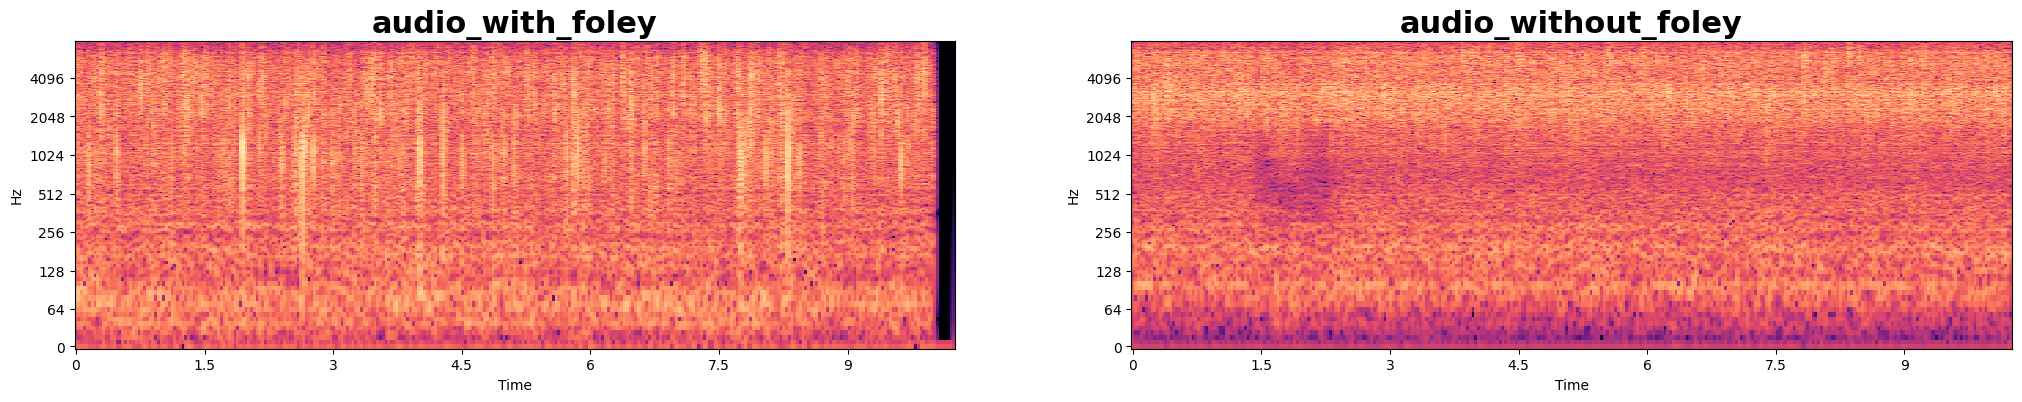

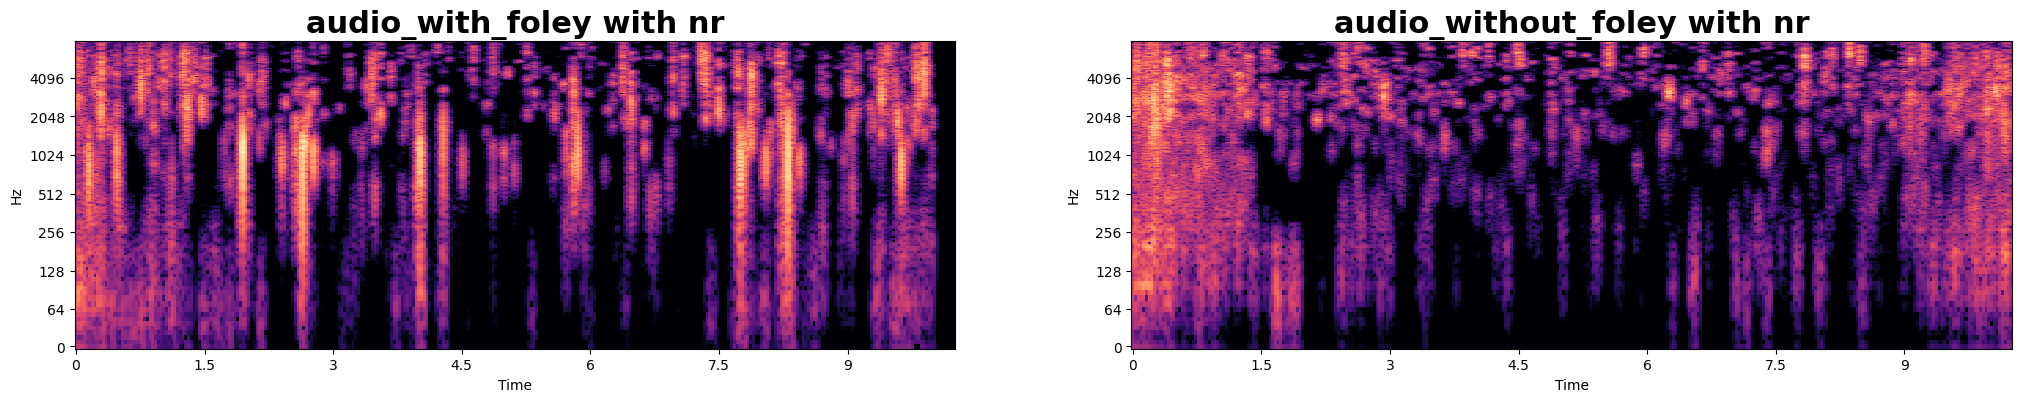

In [117]:
prompt ="Raindrop falling on hand"# "renders a unique personalized effect from one person to another through a 'couple bracelet'"
random_num = np.random.randint(0,65000)
print(random_num)

foley_language_phrase = foley_interpreter(prompt)
audio_with_foley = audio_generator(foley_language_phrase, latent_diffusion, random_num)
audio_with_foley_nr = nr.reduce_noise(y=audio_with_foley, sr=sample_rate)
audio_with_foley_onset_times = librosa.frames_to_time(librosa.onset.onset_detect(y=audio_with_foley_nr, sr=sample_rate))

audio_without_foley = audio_generator(prompt, latent_diffusion, random_num)
audio_without_foley_nr = nr.reduce_noise(y=audio_without_foley, sr=sample_rate)
audio_without_foley_onset_times = librosa.frames_to_time(librosa.onset.onset_detect(y=audio_without_foley_nr, sr=sample_rate))


utils.plot_all([audio_with_foley,audio_without_foley], ['audio_with_foley','audio_without_foley'], num_cols=2)
utils.plot_all([audio_with_foley_nr,audio_without_foley_nr], ['audio_with_foley with nr','audio_without_foley with nr'], num_cols=2)

display(Audio(data=audio_with_foley, rate=sample_rate, normalize=False))
display(Audio(data=audio_without_foley, rate=sample_rate, normalize=False))

audio_with_foley_onset_times[:10],audio_without_foley_onset_times[:10]

num rows= 1


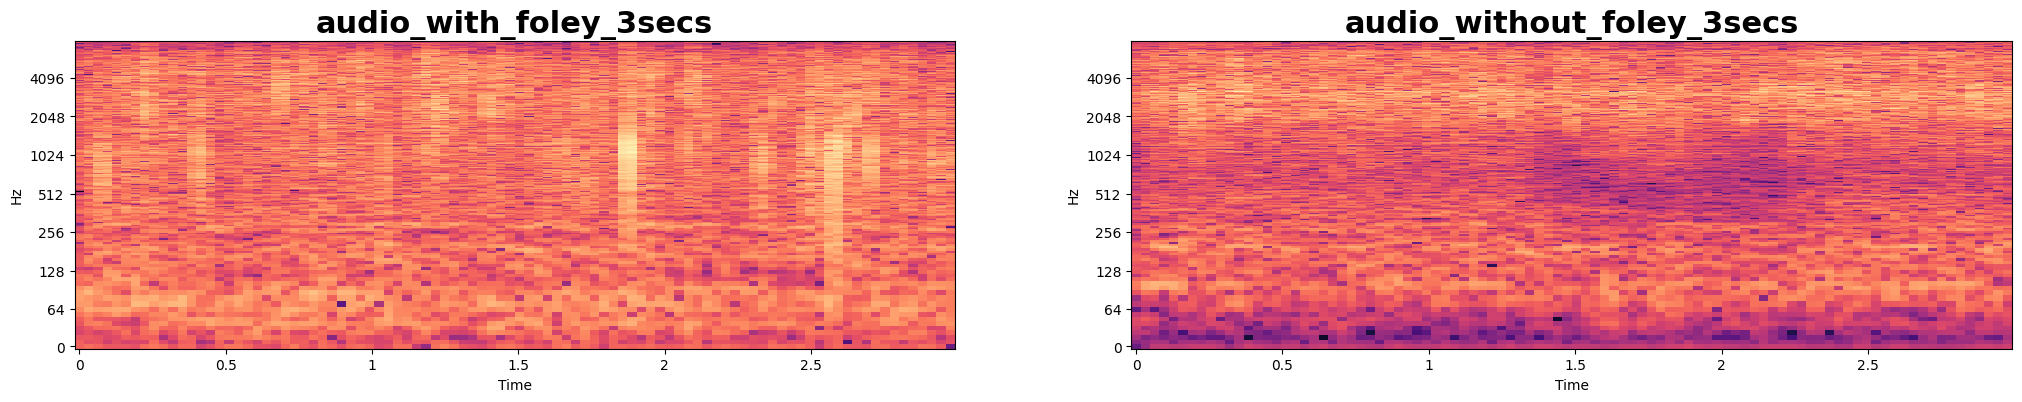

In [118]:
start1 = int(audio_with_foley_onset_times[0]*sample_rate)
audio_with_foley_3secs = audio_with_foley[start1: start1+sample_time*sample_rate]

start2 = int(audio_without_foley_onset_times[0]*sample_rate)
audio_without_foley_3secs = audio_without_foley[start2: start2+sample_time*sample_rate]


utils.plot_all([audio_with_foley_3secs,audio_without_foley_3secs], ['audio_with_foley_3secs','audio_without_foley_3secs'], num_cols=2)
display(Audio(data=audio_with_foley_3secs, rate=sample_rate, normalize=False))
display(Audio(data=audio_without_foley_3secs, rate=sample_rate, normalize=False))

In [119]:
loudness = -20

# MF

Original Loudness basic_none=  -14.429916825775983
Mean Spectral Centroid =  3899.543715556738  Pitch Shift Steps =  47.55966389442307
Loudness before =  -14.562872920703725
Loudness after =  -19.99999957496973
Mean Spectral Centroid =  3899.543715556738  Pitch Shift Steps =  47.55966389442307  Final Shifter Centroid =  253.95445346007142
Mean Spectral Centroid =  3899.543715556738
513 250 64 4
Loudness before =  -21.083840068477915
--
Loudness after =  -21.083840068477915
Original Loudness foley_none=  -27.944157643418055
Mean Spectral Centroid =  3401.9820446205076  Pitch Shift Steps =  45.196506319157336
Loudness before =  -17.595022952427787
Loudness after =  -20.00000017189986
Mean Spectral Centroid =  3401.9820446205076  Pitch Shift Steps =  45.196506319157336  Final Shifter Centroid =  241.77010873884183
Mean Spectral Centroid =  3401.9820446205076
513 218 64 4
Loudness before =  -27.533262713062104
--
Loudness after =  -27.5332627130621
num rows= 1


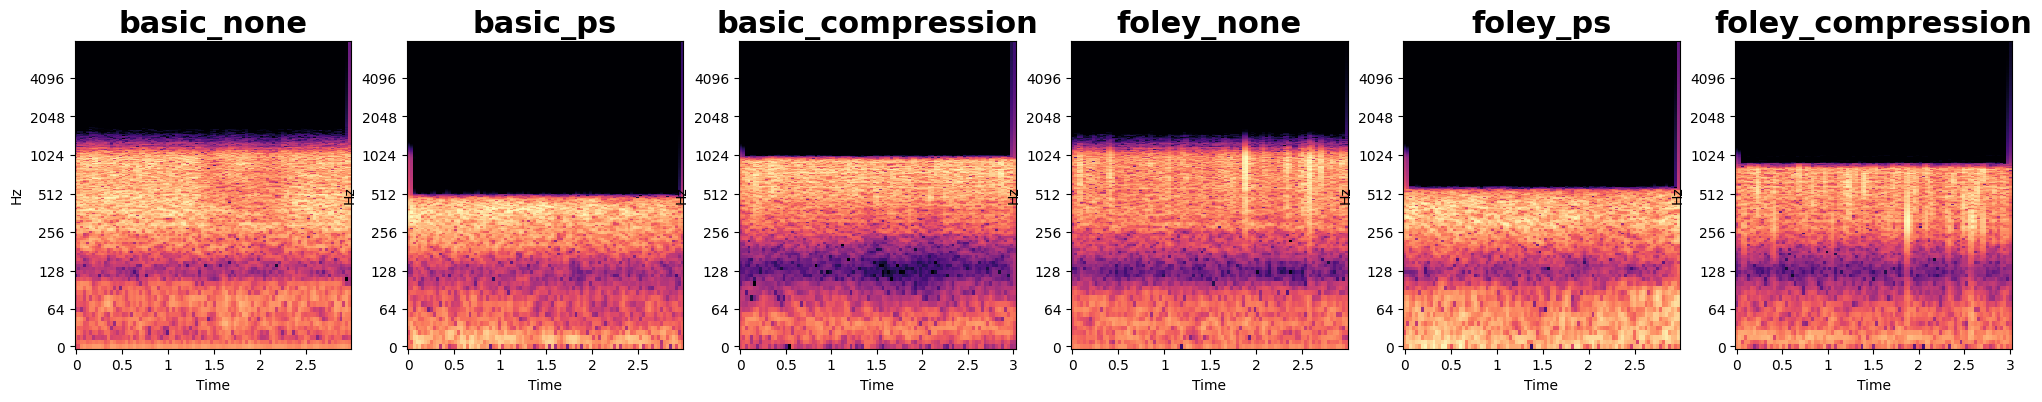

Original Loudness basic_none=  -14.429916825775983
Mean Spectral Centroid =  3899.543715556738  Pitch Shift Steps =  47.55966389442307
Loudness before =  -14.562872920703725
Loudness after =  -19.99999957496973
Mean Spectral Centroid =  3899.543715556738  Pitch Shift Steps =  47.55966389442307  Final Shifter Centroid =  253.95445346007142
Mean Spectral Centroid =  3899.543715556738
513 250 64 4
Loudness before =  -21.083840068477915
--
Loudness after =  -21.083840068477915
Original Loudness foley_none=  -27.944157643418055
Mean Spectral Centroid =  3401.9820446205076  Pitch Shift Steps =  45.196506319157336
Loudness before =  -17.595022952427787
Loudness after =  -20.00000017189986
Mean Spectral Centroid =  3401.9820446205076  Pitch Shift Steps =  45.196506319157336  Final Shifter Centroid =  241.77010873884183
Mean Spectral Centroid =  3401.9820446205076
513 218 64 4
Loudness before =  -27.533262713062104
--
Loudness after =  -27.5332627130621
num rows= 1


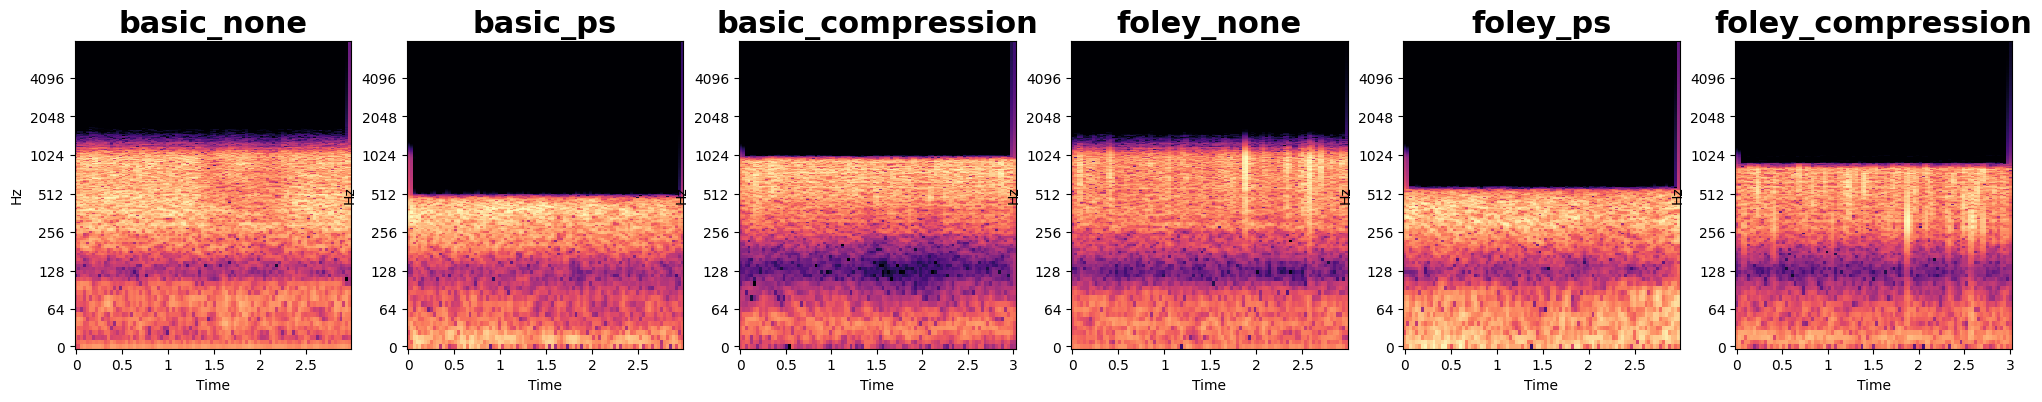

Original Loudness basic_none=  -14.429916825775983
Mean Spectral Centroid =  3899.543715556738  Pitch Shift Steps =  47.55966389442307
Loudness before =  -14.562872920703725
Loudness after =  -19.99999957496973
Mean Spectral Centroid =  3899.543715556738  Pitch Shift Steps =  47.55966389442307  Final Shifter Centroid =  253.95445346007142
Mean Spectral Centroid =  3899.543715556738
513 250 64 4
Loudness before =  -21.083840068477915
--
Loudness after =  -21.083840068477915
Original Loudness foley_none=  -27.944157643418055
Mean Spectral Centroid =  3401.9820446205076  Pitch Shift Steps =  45.196506319157336
Loudness before =  -17.595022952427787
Loudness after =  -20.00000017189986
Mean Spectral Centroid =  3401.9820446205076  Pitch Shift Steps =  45.196506319157336  Final Shifter Centroid =  241.77010873884183
Mean Spectral Centroid =  3401.9820446205076
513 218 64 4
Loudness before =  -27.533262713062104
--
Loudness after =  -27.5332627130621
num rows= 1


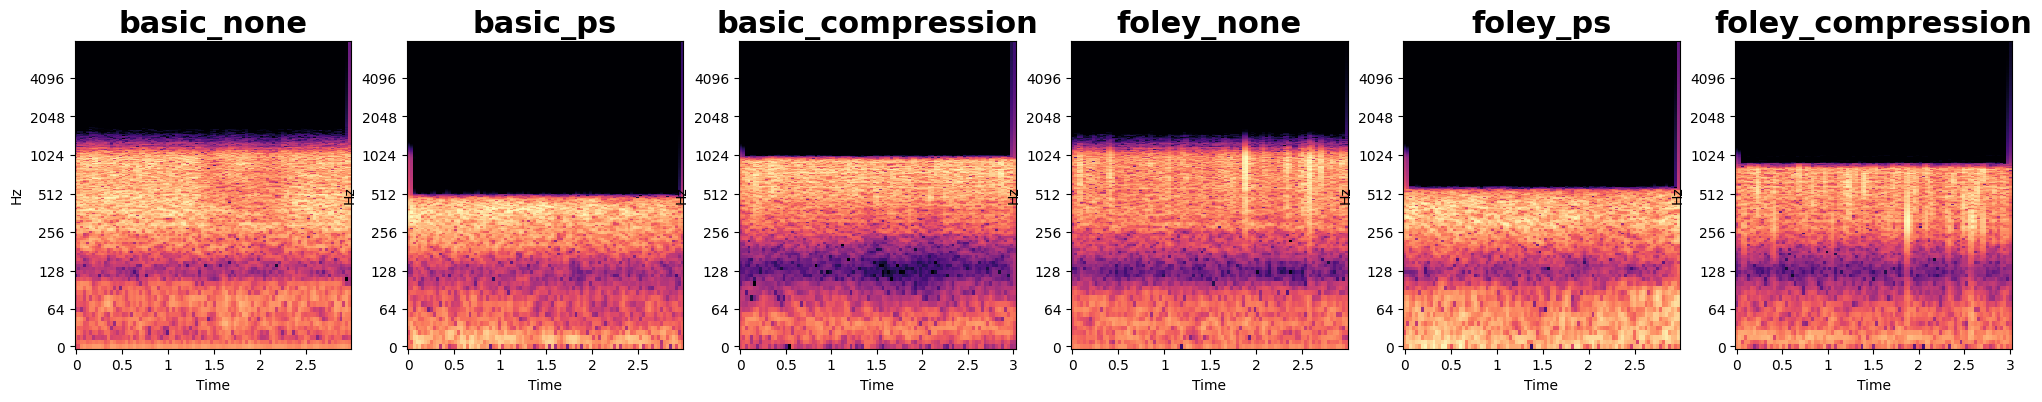

In [152]:
all_audio_map = {}
for type in ["LF", "MF", "HF"]:

    #1 basic_none
    basic_none = audio_without_foley_3secs
    basic_none = butter_bandpass_filter(basic_none, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
    basic_none = equalize_audio(basic_none, type=type, sample_rate=sample_rate)
    print('Original Loudness basic_none= ',loudness_meter.integrated_loudness(basic_none))
    
    #2 basic_ps
    basic_ps = audio_without_foley_3secs
    basic_ps = pitch_shift_centroid(basic_ps, limit=250, sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)
    basic_ps = butter_bandpass_filter(basic_ps, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
    basic_ps = equalize_audio(basic_ps, type=type, sample_rate=sample_rate)
    
    #3 basic_compression
    basic_compression = audio_without_foley_3secs
    basic_compression = compress_spectrogram_with_centroid(basic_compression, limit=1000, hop_length=hop_length, stft_channels=stft_channels, \
                                                        sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)
    basic_compression = butter_bandpass_filter(basic_compression, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
    basic_compression = equalize_audio(basic_compression, type=type, sample_rate=sample_rate)
    
    
    
    #4 foley_none
    foley_none = audio_with_foley_3secs
    foley_none = butter_bandpass_filter(foley_none, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
    foley_none = equalize_audio(foley_none, type=type, sample_rate=sample_rate)
    print('Original Loudness foley_none= ',loudness_meter.integrated_loudness(foley_none))
    
    
    #5 foley_ps
    foley_ps = audio_with_foley_3secs
    foley_ps = pitch_shift_centroid(foley_ps, limit=250, sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)
    foley_ps = butter_bandpass_filter(foley_ps, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
    foley_ps = equalize_audio(foley_ps, type=type, sample_rate=sample_rate)
    
    #6 foley_compression
    foley_compression = audio_with_foley_3secs
    foley_compression = compress_spectrogram_with_centroid(foley_compression, limit=1000, hop_length=hop_length, stft_channels=stft_channels, \
                                                        sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)
    foley_compression = butter_bandpass_filter(foley_compression, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
    foley_compression = equalize_audio(foley_compression, type=type, sample_rate=sample_rate)


    all_audio = {'basic_none':basic_none, 'basic_ps':basic_ps, 'basic_compression':basic_compression,\
                      'foley_none':foley_none,'foley_ps': foley_ps, 'foley_compression':foley_compression}
    all_audio_map[type] = all_audio

    titles = list(all_audio.keys())
    audios = list(all_audio.values())
    utils.plot_all(audios, titles, num_cols=6)
    plt.show()

    audio_widgets = []
    for aud in audios:
        out = widgets.Output()
        with out:
            display(Audio(data=aud, rate=sample_rate, normalize=False))
        audio_widgets.append(out)
    # top_box = widgets.HBox(audio_widgets)
    display(widgets.HBox(audio_widgets))
    
    # top = [basic_none, basic_ps, basic_compression]
    # top_title = ['basic_none_'+type, 'basic_ps_'+type, 'basic_compression_'+type]
    # bottom = [foley_none, foley_ps, foley_compression]
    # bottom_title = ['foley_none_'+type, 'foley_ps_'+type, 'foley_compression_'+type]
    
    
    # utils.plot_all(top, top_title, num_cols=3)
    # utils.plot_all(bottom, bottom_title, num_cols=3)
    
    # audio_widgets = []
    
    # for aud in top:
    #     out = widgets.Output()
    #     with out:
    #         display(Audio(data=aud, rate=sample_rate, normalize=False))
    #     audio_widgets.append(out)
    # top_box = widgets.HBox(audio_widgets)
    
    # audio_widgets = []
    # for aud in bottom:
    #     out = widgets.Output()
    #     with out:
    #         display(Audio(data=aud, rate=sample_rate, normalize=False))
    #     audio_widgets.append(out)
    # bottom_box = widgets.HBox(audio_widgets)
    
    # widgets.VBox([top_box, bottom_box])


In [153]:
prompt_dir_name = prompt.lower().replace(" ","_")
os.makedirs("samples_new/"+prompt_dir_name, exist_ok=True)

for type in all_audio_map.keys():
    audio_map = all_audio_map[type]
    sf.write("samples_new/"+prompt_dir_name+"/"+type+"_"+"basic_none.wav", audio_map['basic_none'], samplerate=sample_rate)
    sf.write("samples_new/"+prompt_dir_name+"/"+type+"_"+"basic_ps.wav", audio_map['basic_ps'], samplerate=sample_rate)
    sf.write("samples_new/"+prompt_dir_name+"/"+type+"_"+"basic_compression.wav", audio_map['basic_compression'], samplerate=sample_rate)
    
    sf.write("samples_new/"+prompt_dir_name+"/"+type+"_"+"foley_none.wav", audio_map['foley_none'], samplerate=sample_rate)
    sf.write("samples_new/"+prompt_dir_name+"/"+type+"_"+"foley_ps.wav", audio_map['foley_ps'], samplerate=sample_rate)
    sf.write("samples_new/"+prompt_dir_name+"/"+type+"_"+"foley_compression.wav", audio_map['foley_compression'], samplerate=sample_rate)


Loudness before =  -16.496249424399252
Loudness after =  -19.999999999999996
Original Loudness basic_none=  -33.919669013640856
Mean Spectral Centroid =  3264.8516292652725  Pitch Shift Steps =  44.484209162196635
Loudness before =  -24.63964682249313
--
Loudness after =  -24.639647512674713
Mean Spectral Centroid =  3264.8516292652725  Pitch Shift Steps =  44.484209162196635  Final Shifter Centroid =  209.65258235465146
Loudness before =  -27.21517725958541
--
Loudness after =  -27.215177259585392
Mean Spectral Centroid =  3264.8516292652725
513 209 64 4
Loudness before =  -23.586161861060898
--
Loudness after =  -23.586161861060916
Loudness before =  -21.02861492763236
--
Loudness after =  -21.028614927632383
Loudness before =  -16.814539481407014
Loudness after =  -20.00000000000003
Original Loudness foley_none=  -20.00000000000003
Mean Spectral Centroid =  667.9117473407529  Pitch Shift Steps =  17.012752726945052
Loudness before =  -18.619032855712383
Loudness after =  -20.0000001

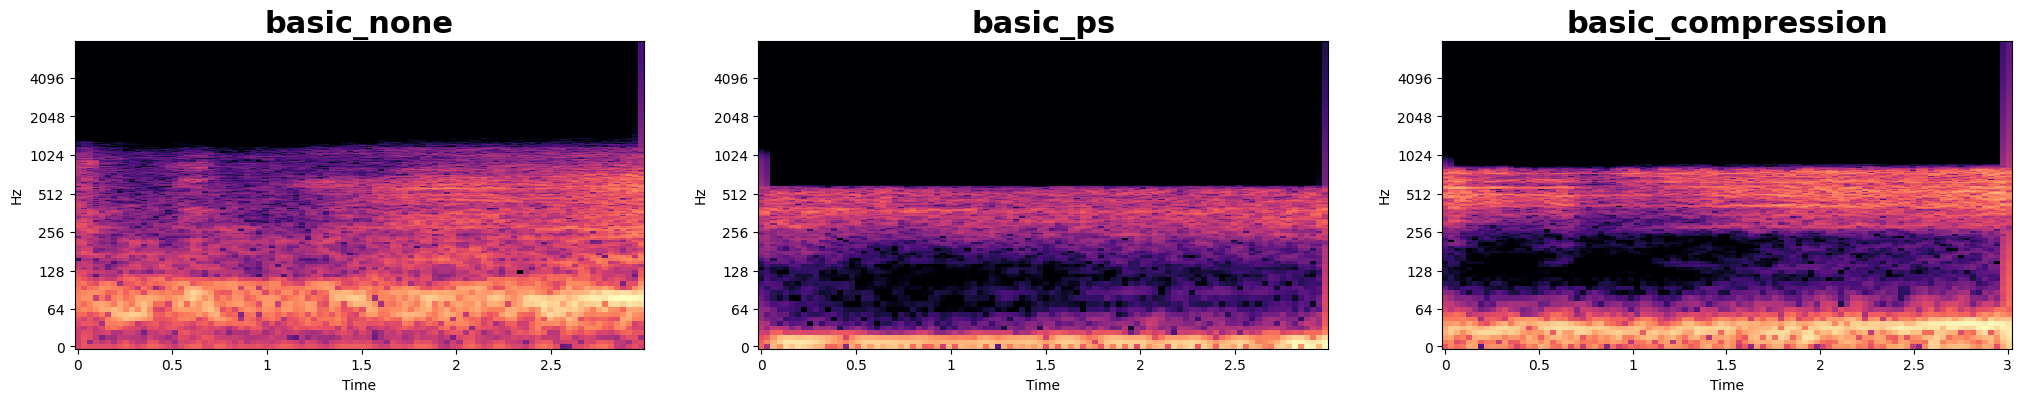

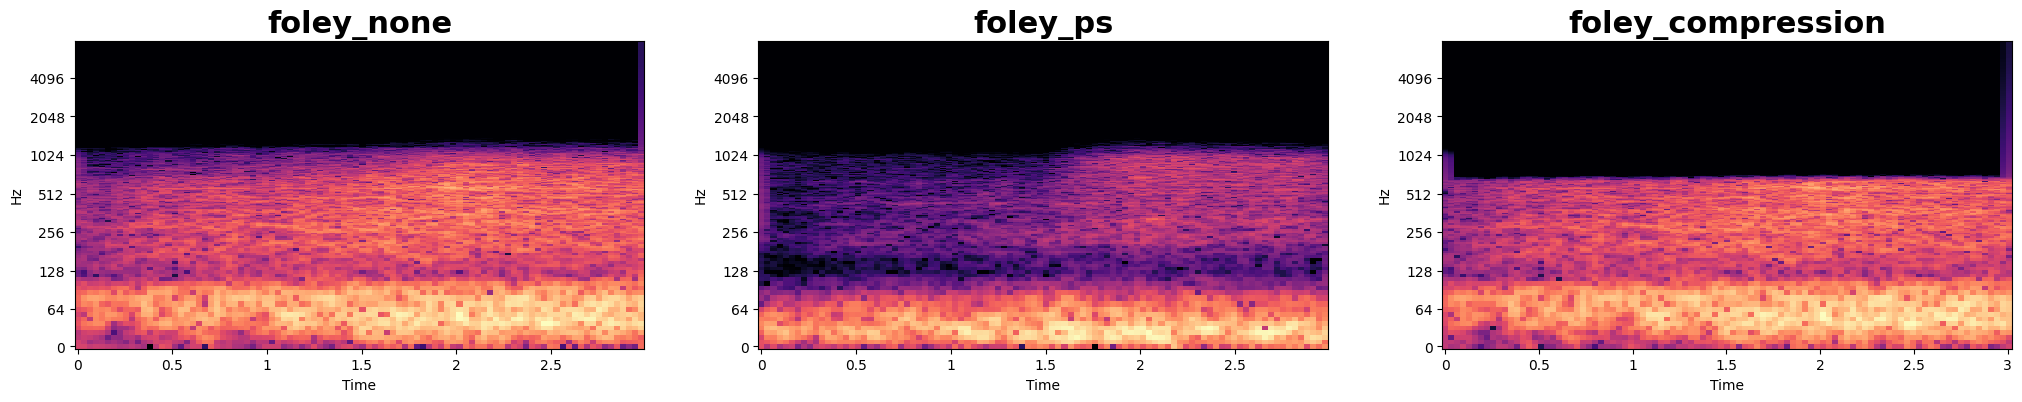

In [97]:

#1 basic_none
basic_none = audio_without_foley_3secs
# basic_none = butter_bandpass_filter(basic_none, highcut=1000, fs=sample_rate, lowcut=None, order=5, btype='lowpass')
basic_none = equalize_audio(basic_none, sample_rate, loudness_meter=loudness_meter, loudness=loudness)
basic_none = butter_bandpass_filter(basic_none, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
# basic_none = cheby_lowpass(basic_none, lowcut=1000, fs=sample_rate, order=17, btype='lowpass')
print('Original Loudness basic_none= ',loudness_meter.integrated_loudness(basic_none))

#2 basic_lp
# basic_lp = audio_without_foley_3secs
# basic_lp = butter_bandpass_filter(basic_lp, highcut=1000, fs=sample_rate, lowcut=None, order=2, btype='lowpass')
# basic_lp = equalize_audio(basic_lp, sample_rate, loudness_meter=loudness_meter, loudness=loudness)

#3 basic_ps
basic_ps = audio_without_foley_3secs
basic_ps = pitch_shift_centroid(basic_ps, limit=250, sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)
basic_ps = butter_bandpass_filter(basic_ps, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
basic_ps = equalize_audio(basic_ps, sample_rate, loudness_meter=loudness_meter, loudness=loudness)

#4 basic_compression
basic_compression = audio_without_foley_3secs
basic_compression = compress_spectrogram_with_centroid(basic_compression, limit=1000, hop_length=hop_length, stft_channels=stft_channels, \
                                                    sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)
basic_compression = butter_bandpass_filter(basic_compression, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
basic_compression = equalize_audio(basic_compression, sample_rate, loudness_meter=loudness_meter, loudness=loudness)



#5 foley_none
foley_none = audio_with_foley_3secs
foley_none = butter_bandpass_filter(foley_none, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
foley_none = equalize_audio(foley_none, sample_rate, loudness_meter=loudness_meter, loudness=loudness)
print('Original Loudness foley_none= ',loudness_meter.integrated_loudness(foley_none))

#6 foley_lp
# foley_lp = audio_with_foley_3secs
# foley_lp = butter_bandpass_filter(foley_lp, highcut=1000, fs=sample_rate, lowcut=None, order=2, btype='lowpass')
# foley_lp = equalize_audio(foley_lp, sample_rate, loudness_meter=loudness_meter, loudness=loudness)

#7 foley_ps
foley_ps = audio_with_foley_3secs
foley_ps = pitch_shift_centroid(foley_ps, limit=250, sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)
foley_ps = butter_bandpass_filter(foley_ps, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
foley_ps = equalize_audio(foley_ps, sample_rate, loudness_meter=loudness_meter, loudness=loudness)

#4 foley_compression
foley_compression = audio_with_foley_3secs
foley_compression = compress_spectrogram_with_centroid(foley_compression, limit=1000, hop_length=hop_length, stft_channels=stft_channels, \
                                                    sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)
foley_compression = butter_bandpass_filter(foley_compression, highcut=1000, fs=sample_rate, lowcut=None, order=17, btype='lowpass')
foley_compression = equalize_audio(foley_compression, sample_rate, loudness_meter=loudness_meter, loudness=loudness)




top = [basic_none, basic_ps, basic_compression]
top_title = ['basic_none', 'basic_ps', 'basic_compression']
bottom = [foley_none, foley_ps, foley_compression]
bottom_title = ['foley_none', 'foley_ps', 'foley_compression']


utils.plot_all(top, top_title, num_cols=3)
utils.plot_all(bottom, bottom_title, num_cols=3)

audio_widgets = []

for aud in top:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate, normalize=False))
    audio_widgets.append(out)
top_box = widgets.HBox(audio_widgets)

audio_widgets = []
for aud in bottom:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate, normalize=False))
    audio_widgets.append(out)
bottom_box = widgets.HBox(audio_widgets)

widgets.VBox([top_box, bottom_box])


In [98]:
prompt_dir_name = prompt.lower().replace(" ","_")
os.makedirs("samples3/"+prompt_dir_name, exist_ok=True)

sf.write("samples3/"+prompt_dir_name+"/"+"basic_none.wav", basic_none, samplerate=sample_rate)
sf.write("samples3/"+prompt_dir_name+"/"+"basic_ps.wav", basic_ps, samplerate=sample_rate)
sf.write("samples3/"+prompt_dir_name+"/"+"basic_compression.wav", basic_compression, samplerate=sample_rate)

sf.write("samples3/"+prompt_dir_name+"/"+"foley_none.wav", foley_none, samplerate=sample_rate)
sf.write("samples3/"+prompt_dir_name+"/"+"foley_ps.wav", foley_ps, samplerate=sample_rate)
sf.write("samples3/"+prompt_dir_name+"/"+"foley_compression.wav", foley_compression, samplerate=sample_rate)
